<a href="https://colab.research.google.com/github/OlesjaBogomaz/BaRDIC/blob/main/%D0%9C%D0%BE%D0%B4%D0%B5%D0%BB%D0%B8%D1%80%D0%BE%D0%B2%D0%B0%D0%BD%D0%B8%D0%B5_%D0%B4%D0%BB%D1%8F_%D0%B1%D0%B0%D1%80%D0%B4%D0%B8%D0%BA%D0%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Автор методики симуляции: Миронов АА

Автор кода: Богомаз ОД

На английский примечания переведу позже

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! cd /content/drive/MyDrive/simulation_bardic/

In [ ]:
!pwd

/content


In [ ]:

import pandas as pd
chr_sizes = pd.read_csv('/content/drive/MyDrive/simulation_bardic/mm10.chrom.sizes.txt', sep='\t', header=None, names=['chr', 'len'])
contacts = pd.read_csv('/content/drive/MyDrive/simulation_bardic/ES.chr18.tab', sep='\t')

## Cis and trans probabilities

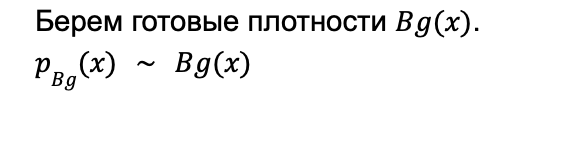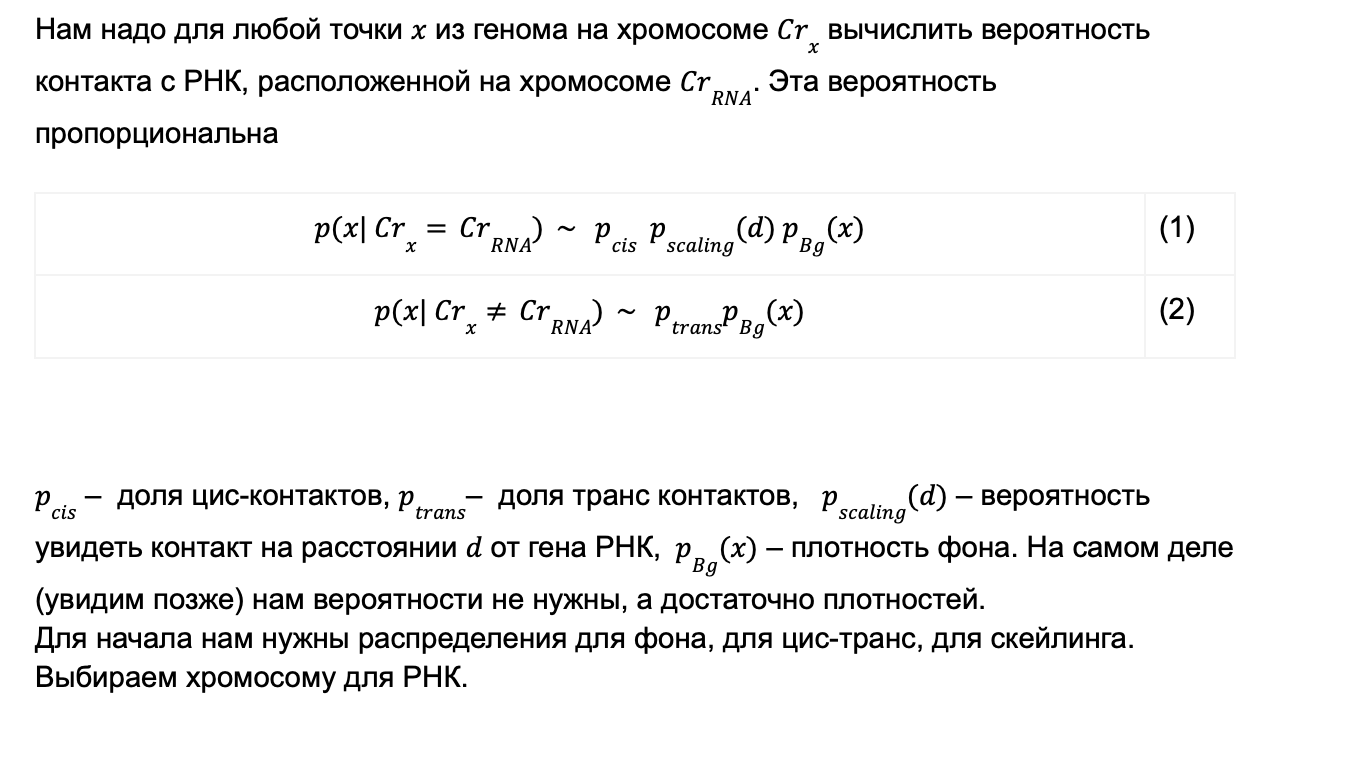

In [ ]:
import random
random.seed(42)
rnas = contacts[['gene_name', 'rna_chr'] ].groupby(by=['gene_name']).count().reset_index()
rnas = list(rnas.gene_name[rnas.rna_chr>1000])
selected_rna = random.choices(rnas, k=10)
p_cis = []
for rna in selected_rna:
    n_cis = len(contacts[(contacts.gene_name == rna) & (contacts.dna_chr == 'chr18')])
    l_cis = chr_sizes.len[chr_sizes.chr == 'chr18'].item()
    n = len(contacts[(contacts.gene_name == rna)])
    l = sum(chr_sizes.len)
    p_cis.append(((n_cis/l_cis)/(n/l)))

p_cis = sum(p_cis)/10*l_cis/l
p_trans = 1-p_cis
p_trans, p_cis

(0.47433642305930324, 0.5256635769406968)

## Background Probability

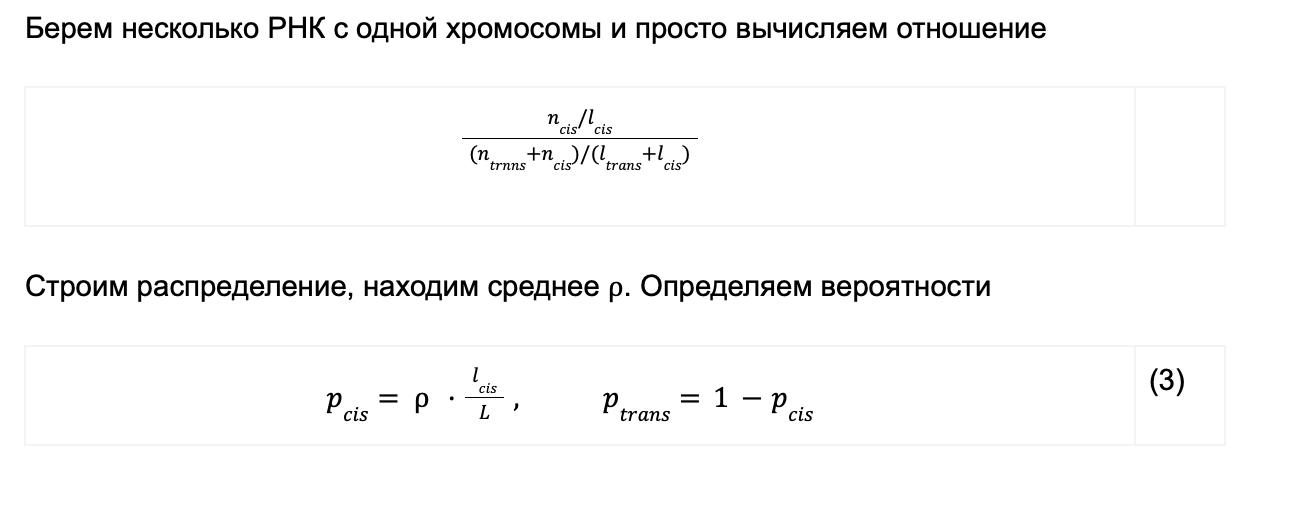

In [ ]:
bg = pd.read_csv('/content/drive/MyDrive/simulation_bardic/bg_for18.tsv', sep='\t')

In [ ]:
random.seed(42)
len_rnas = len(bg.gene_name.unique())
len_chr = chr_sizes.len[chr_sizes.chr == 'chr18'].item()
p_bg = len(bg)/len_rnas/len_chr
# Предлагаю здесь посчитать так, чтобы была плотность для всех фоновых РНК
# p_bg = len(bg)/len_chr

p_bg

6.188690949696581e-07

## Scaling estimation

Для любой РНК стандартным образом строим распределение скейлинга

 log dens = log dist

 Приближаем его сплайном 3-ей степени


In [ ]:
pip install scipy

In [ ]:
random.seed(42)
rnas = contacts[['gene_name', 'rna_chr'] ].groupby(by=['gene_name']).count().reset_index()
rnas = list(rnas.gene_name[rnas.rna_chr>20000])
selected_for_scaling = random.choices(rnas, k=10)
rnas


['AW554918',
 'Apc',
 'Commd10',
 'Csnk1a1',
 'Ctnna1',
 'Dmxl1',
 'Epb41l4a',
 'Fbxo15',
 'LSU-rRNA_Hsa_469',
 'Nedd4l',
 'Pias2',
 'Snhg4_2',
 'Tcf4',
 'Wac',
 'Wdr33',
 'X_18_7703_a_mm10',
 'Zbtb7c',
 'Zfp407']

In [ ]:
import math
coord_cent = []
dist_norm_log = []
bg = pd.read_csv('/content/drive/MyDrive/simulation_bardic/bg_for18.tsv', sep='\t')
bg = bg[['dna_start', 'dna_end']]
bg['weight'] = 1/len(contacts[contacts.gene_type == 'protein_coding'].gene_name.unique())

dist_bg = [0.001 for i in range(0, len_chr, 1000000) ]

coord = [i for i in range(0, len_chr, 1000000)]

for index, row in bg.iterrows():
   dist_bg[int(row['dna_start'].item()//1000000)] += row['weight']




Snhg4_2


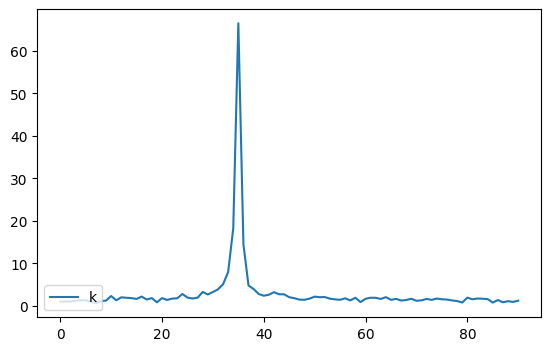

AW554918


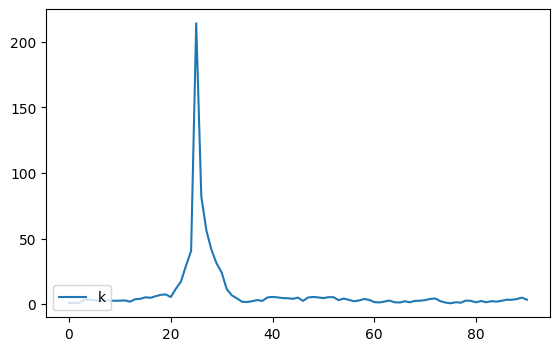

Ctnna1


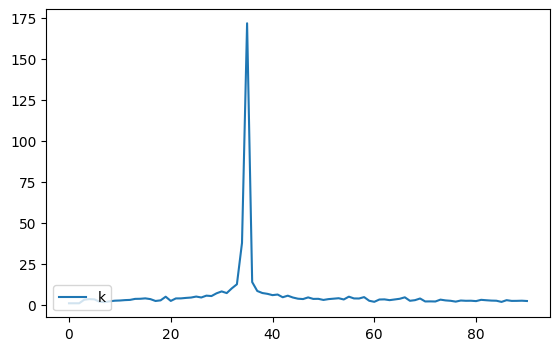

Ctnna1


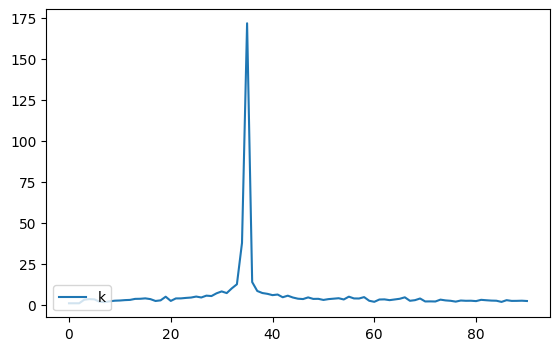

Wac


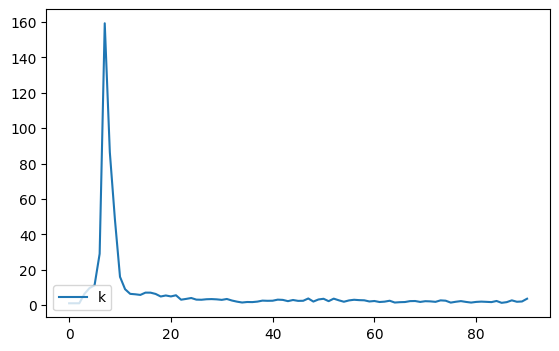

Tcf4


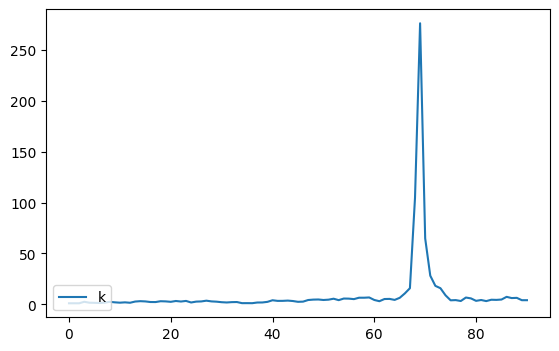

Zbtb7c


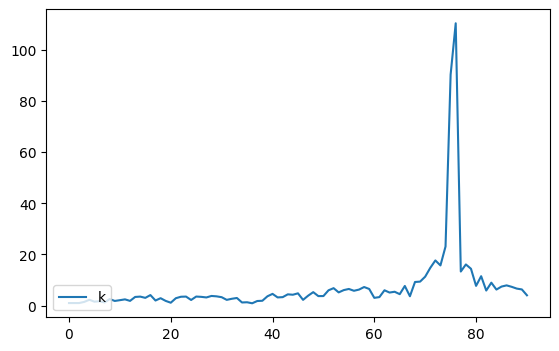

Apc


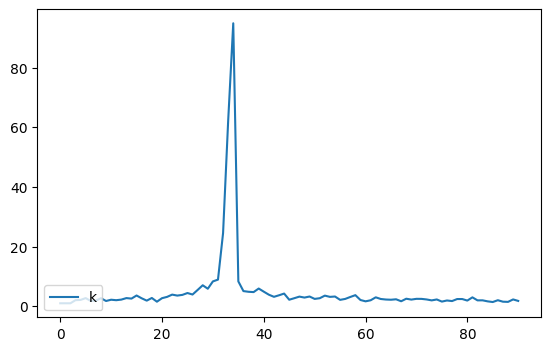

Fbxo15


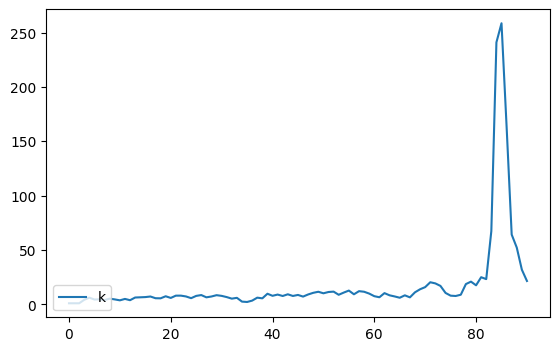

AW554918


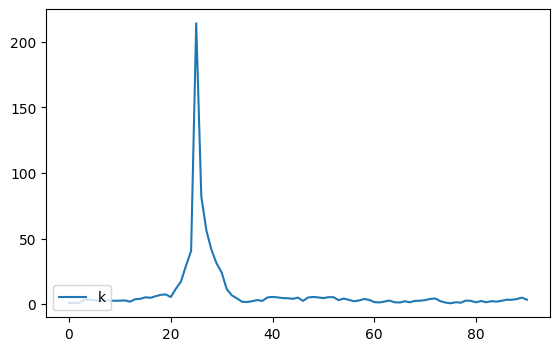

In [ ]:
import matplotlib.pyplot as plt

dist_norm_log = []
coord_cent = []
for rna in selected_for_scaling:

  selected_only = contacts[ (contacts.gene_name == rna) & (contacts.dna_chr == 'chr18')]
  selected_for_scaling_coord = (selected_only['rna_start'].min() + selected_only.rna_end.max())/2

  print(rna)
  selected_only = selected_only[['dna_start', 'dna_end']]
  dist = [0.001 for i in range(0, len_chr, 1000000) ]
  for index, row in selected_only.iterrows():
      dist[row['dna_start']//1000000] += 1
  dist_norm = []
  for i in range(len(dist)):
      dist_norm.append(dist[i]/dist_bg[i])
  dist_norm_log.extend(dist_norm)
  coord_cent.extend([abs(i-selected_for_scaling_coord) for i in range(0, len_chr, 1000000)])

  fig, ax = plt.subplots(figsize=(6.5, 4))
  ax.plot(dist_norm, label='k')
  ax.legend(loc='lower left', ncol=2)
  plt.show()
dist_norm_log_sort = [math.log(x) for _,x in sorted(zip(coord_cent, dist_norm_log))]
coord_cent_sort = sorted(coord_cent)

In [ ]:
import numpy as np
from scipy.interpolate import splrep, splev

import math

In [ ]:
len(dist_norm_log_sort)

910

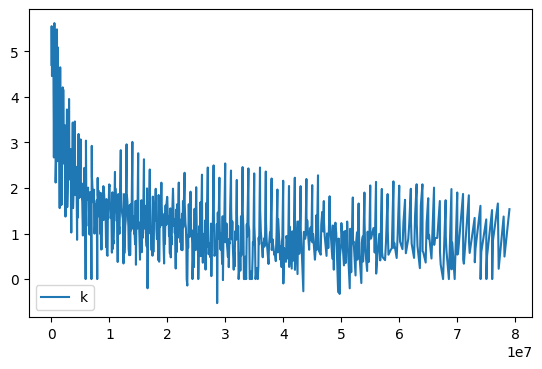

In [ ]:

fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(coord_cent_sort[:900], dist_norm_log_sort[:900], label='k')
ax.legend(loc='lower left', ncol=2)


In [ ]:
cs1 = splrep(coord_cent_sort[:900], dist_norm_log_sort[:900], k=3, s=len(coord_cent_sort)*3-math.sqrt(2*len(coord_cent_sort)*3))

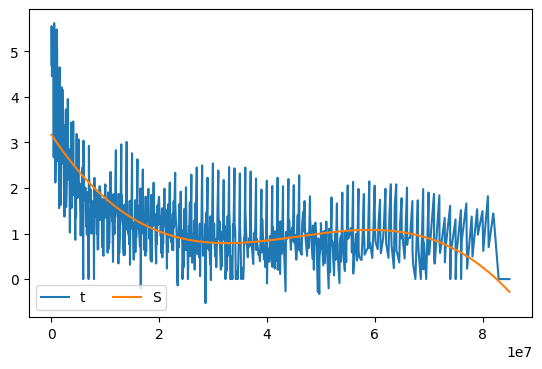

In [ ]:
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(coord_cent_sort, dist_norm_log_sort, label='t')
ax.plot(coord_cent_sort, splev(coord_cent_sort, cs1), label="S")
ax.legend(loc='lower left', ncol=2)
plt.show()

## Modelling

### making background

Тут изменение относительно предложения Миронова: фон семплируется из равномерного распределения

In [ ]:
random.seed(42)
len_cis = 100*(10**6)
len_trans = 2*(10**9)
cis_count = round(p_bg*len_cis+random.normalvariate(mu=0, sigma=30000))

trans_count = round(p_bg*len_trans+random.normalvariate(mu=0, sigma=3000))

cis_chrom_bg = random.choices(range(0, len_cis), k = cis_count)
trans_chrom_bg = random.choices(range(0, len_trans), k = trans_count)

dist_bg_cis = [0.000001 for i in range(0, len_cis, 500)]
dist_bg_trans = [0.000001 for i in range(0, len_trans, 500)]

for coordinate in cis_chrom_bg:
    dist_bg_cis[coordinate//500] += 1

for coordinate in trans_chrom_bg:
    dist_bg_trans[coordinate//500] += 1


### making trans distribution

Опираясь на фон добавляем контакты через восстановление функции распределения

In [ ]:
b = [0]
for i in range(len(dist_bg_trans)):
    b.append(b[-1]+dist_bg_trans[i])


In [ ]:
random.seed(22)
import bisect
cis_count = int(10000*p_cis )
trans_count = int(10000*p_trans)
trans = []
for i in range(trans_count):
    y = random.randint(0, int(b[-1]))
    l = bisect.bisect_left(b, y)
    r = bisect.bisect_right(b, y)
    to_add = l*500 + (y-b[l])*500/(b[min(r, len(b)-1)]-b[l]+0.00001)
    trans.append(to_add)


### making cis destribution

То же, но с учетом модели скейлинга

In [ ]:
def s(x):
    return math.e**splev(abs(x), cs1)

In [ ]:
b = [0]
for i in range(len(dist_bg_cis)):
    b.append(b[-1]+dist_bg_cis[i])


In [ ]:
random.seed(42)
coord_rna = random.randint(0, len_cis)
g = []
for i in range(len(dist_bg_cis)):
    g.append(s(i*500-coord_rna)*b[i])



In [ ]:
c = [0]
for i in range(len(dist_bg_cis)):
    c.append(c[-1]+g[i])

In [ ]:
random.seed(12)
cis = []
for i in range(cis_count):
  y = random.randint(0, int(c[-1]))
  l = bisect.bisect_left(c, y)
  r = bisect.bisect_right(c, y)
  to_add = (l+r)*250
  cis.append(to_add)


### making peaks

Чтобы добавить пики мы к некоторым сгенерированным контактам добавим еще контакты.
Берем случайный контакт x из полученной выборки контактов. Из экспоненциального распределения сэмплируем число дополнительных контактов.


In [ ]:
trans_peak_x = random.choice(trans)
cis_peak_x = random.choice(cis)
n_peak_cis = -round(100*math.log(random.random()))
n_peak_trans = -round(100*math.log(random.random()))

In [ ]:
min(cis)

797500

In [ ]:
dist_cis = [0 for i in range(0, len_cis, 10000)]
print(max(cis)//10000, len(dist_cis))
for i in cis+[random.normalvariate(mu=cis_peak_x, sigma=3000) for i in range(int(n_peak_cis))]:
      dist_cis[int(i)//10000] += 1

9999 10000


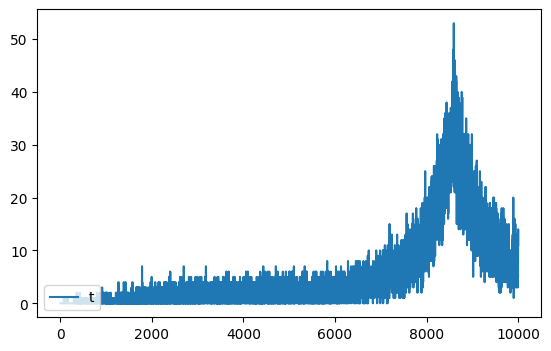

In [ ]:
fig, ax = plt.subplots(figsize=(6.5, 4))
ax.plot(dist_cis, label='t')
ax.legend(loc='lower left', ncol=2)
plt.show()

Вся описанная выше процедура в одном окошке, чтоб генерировать разные варианты входных данных по сетке.

In [ ]:
for mean_n_peak in range(10, 1000, 100):
    for sigma in range(3000, 6000, 1000):

      random.seed(42)
      len_cis = 100*(10**6)
      len_trans = 2*(10**9)
      cis_count = round(p_bg*len_cis)

      trans_count = round(p_bg*len_trans)
      reads_number = p_bg*(len_cis+len_trans)
      cis_chrom_bg = random.choices(range(0, len_cis), k = cis_count)
      trans_chrom_bg = random.choices(range(0, len_trans), k = trans_count)
      dist_bg_cis = [0.000001 for i in range(0, len_cis, 500)]
      dist_bg_trans = [0.000001 for i in range(0, len_trans, 500)]

      for coordinate in cis_chrom_bg:
          dist_bg_cis[coordinate//500] += 1

      for coordinate in trans_chrom_bg:
          dist_bg_trans[coordinate//500] += 1

      """### making trans distribution"""

      b = [0]
      for i in range(len(dist_bg_trans)):
          b.append(b[-1]+dist_bg_trans[i])

      random.seed(22)
      import bisect
      cis_count = int(reads_number*p_cis)
      trans_count = int(reads_number*p_trans)
      # здесь как раз изначальная формула p_bg = len(bg)/len_rnas/len_chr, так как генерируем фоновые контакты от одной РНК.
      #cis_count = int(reads_number*p_cis/len_rnas)
      #trans_count = int(reads_number*p_trans/len_rnas)

      trans = []
      for i in range(trans_count):
          y = random.randint(0, int(b[-1]))
          l = bisect.bisect_left(b, y)
          r = bisect.bisect_right(b, y)
          to_add = l*500 + (y-b[l])*500/(b[min(r, len(b)-1)]-b[l]+0.00001)
          # не уверена, но r совпадает с l, как правило. У меня корректно работало с r + 1
          # to_add = l*500 + (y-b[l])*500/(b[min(r+1, len(b)-1)]-b[l]+0.00001)
          trans.append(int(to_add))

      """### making cis destribution"""

      def s(x):
          return math.e**splev(abs(x), cs1)

      b = [0]
      for i in range(len(dist_bg_cis)):
          b.append(b[-1]+dist_bg_cis[i])

      random.seed(42)
      coord_rna = random.randint(0, len_cis)
      g = []
      for i in range(len(dist_bg_cis)):
          g.append(s(i*500-coord_rna)*b[i])

      c = [0]
      for i in range(len(dist_bg_cis)):
          c.append(c[-1]+g[i])

      random.seed(12)
      cis = []
      for i in range(cis_count):
        y = random.randint(0, int(c[-1]))
        l = bisect.bisect_left(c, y)
        r = bisect.bisect_right(c, y)
        to_add = (l+r)*250
        cis.append(int(to_add))

      """### making peaks"""

      trans_peak_x = random.choice(trans)
      cis_peak_x = random.choice(cis)
      n_peak_cis = - round(mean_n_peak*math.log(random.random()))
      n_peak_trans = -round(mean_n_peak*math.log(random.random()))

      cis_with_peaks = cis+[int(random.normalvariate(mu=cis_peak_x, sigma=sigma)) for i in range(int(n_peak_cis))]
      trans_with_peaks = trans+[int(random.normalvariate(mu=cis_peak_x, sigma=sigma)) for i in range(int(n_peak_trans))]
      # mu заменить на trans
      #trans_with_peaks = trans+[int(random.normalvariate(mu=trans_peak_x, sigma=sigma)) for i in range(int(n_peak_trans))]

      """make bed file"""
      df_cis_bg = pd.DataFrame(cis_chrom_bg)
      df_trans_bg = pd.DataFrame(trans_chrom_bg)
      df_cis_bg['chr'] = 'cis'
      df_trans_bg['chr'] = 'trans'
      df_cis_bg['name'] = 'bg'
      df_trans_bg['name'] = 'bg'
      df_cis_bg['end'] = df_cis_bg[0]
      df_cis_bg['end'] = df_cis_bg['end']+23
      df_trans_bg['end'] = df_trans_bg[0]
      df_trans_bg['end'] = df_trans_bg['end']+23

      df_cis = pd.DataFrame(cis_with_peaks)
      df_trans = pd.DataFrame(trans_with_peaks)
      df_cis['chr'] = 'cis'
      df_trans['chr'] = 'trans'
      df_cis['name'] = 'track'
      df_trans['name'] = 'track'
      df_cis['end'] = df_cis[0]
      df_cis['end'] = df_cis['end']+23
      df_trans['end'] = df_trans[0]
      df_trans['end'] = df_trans[0]+23

      df = pd.concat([df_cis, df_trans, df_trans_bg, df_cis_bg])

      df[['chr', 0, 'end', 'name' ]].to_csv('/content/drive/MyDrive/simulation_bardic/'+str(mean_n_peak)+'_'+str(sigma)+'.bed', sep='\t', header=False, index=False)

In [ ]:
trans_peak_x
cis_peak_x

90058000

In [ ]:
import random
import bisect